# Interpretability of the multiclass structure segmentation model

This notebook visualizes the results of the occlusion analysis on the models designed for multiclass biological structure segmentation.

Predictions and analysis are performed on test data.

In [4]:
import os
import gc
import numpy as np
import tifffile as tiff
import re
import fiona
import cv2
import time
import joblib
import torch
import torch.nn.functional as F
import matplotlib

from PIL import Image
from glob import glob
import matplotlib.patches as mpatches

from multiprocess import Pool
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, RocCurveDisplay

In [81]:
mode = "binary"
test_wsis = [f'../output/structure_seg/7026_part_2.npy']
downscaled = True

## Source data

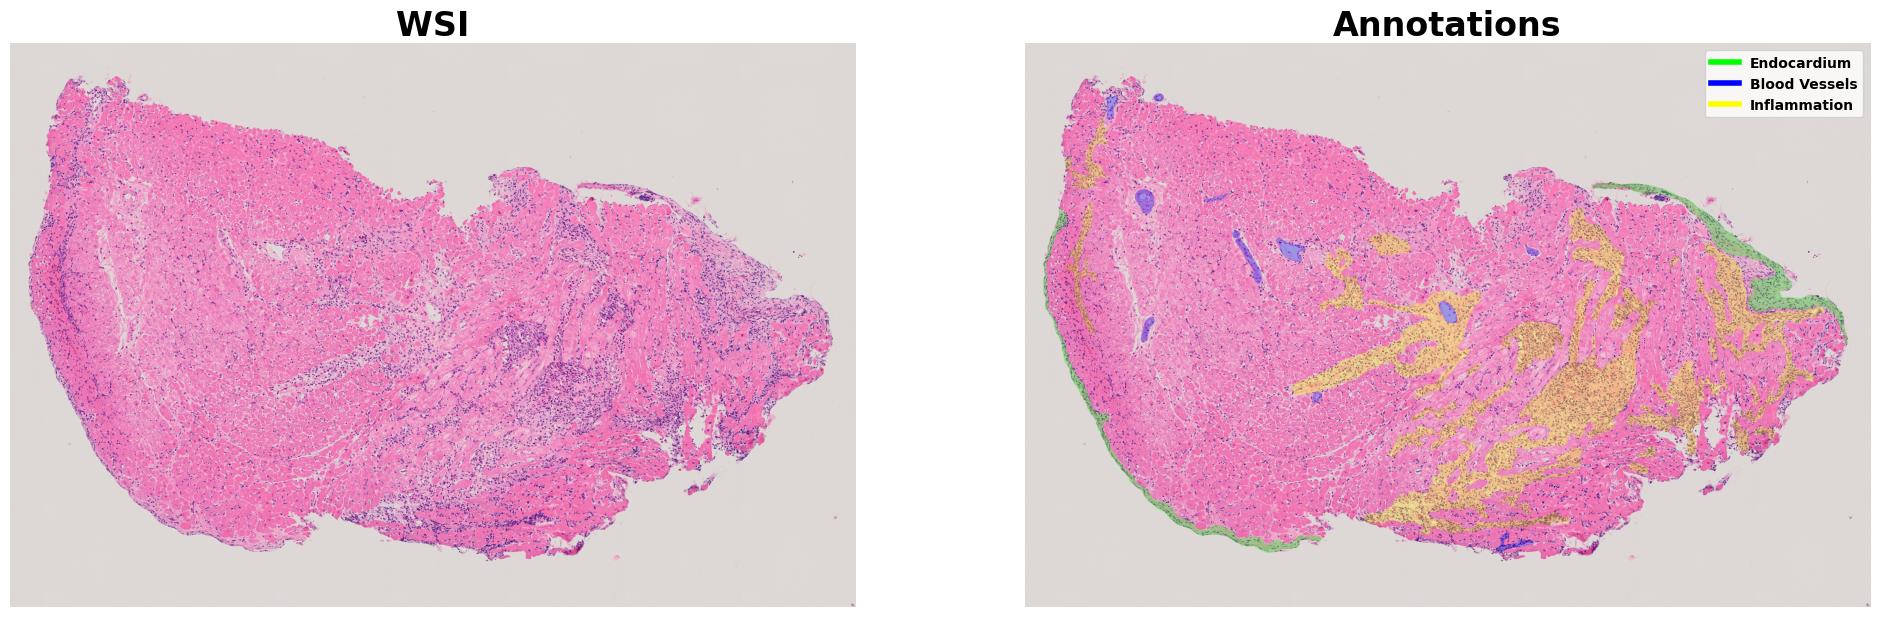

In [16]:
wsi_path = '../output/structure_seg/7026_part_2.npy'
part = 2
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(24,14))
img = np.load(wsi_path)
org = img[4, :, :]
out = np.load(wsi_path)

labels = np.where((out[4, :, :] == 5) | (out[4, :, :] == 6), 3, out[4, :, :])
labels = np.where(labels == 7, 1, labels)

out = out[:3]
labels = labels


out = cv2.resize(out.transpose(1, 2, 0), (out.shape[2]//2, out.shape[1]//2)).transpose(2, 0, 1)
labels = cv2.resize(labels, (labels.shape[1]//2, labels.shape[0]//2))

org_out = out.copy()
for color, c_idx in zip([(0, 255, 0), (0, 0, 255), (255, 255, 0)], range(1, 4)):
    labels_contours, _ = cv2.findContours(np.where(labels == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if c_idx == 1:
        org_out = np.ascontiguousarray(org_out.transpose(1, 2, 0), dtype=np.uint8)

    cv2.drawContours(org_out, labels_contours, -1, color, thickness=cv2.FILLED)   

custom_lines = [Line2D([0], [0], color="#00ff00", lw=4),
                Line2D([0], [0], color="#0000ff", lw=4),
                Line2D([0], [0], color="#ffff00", lw=4)]

ax[0].imshow(out.transpose(1, 2, 0))
ax[0].set_title("WSI", fontsize=24, fontweight='bold')
ax[0].axis('off')

alpha = 0.3
org_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, org_out, alpha, 0)
ax[1].imshow(org_out)
# ax[0, 1].imshow(np.where(l_pred==0, np.nan, l_pred), vmin=1, vmax=4, cmap='Dark2')
ax[1].set_title("Annotations", fontsize=24, fontweight='bold')
ax[1].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
ax[1].axis('off')
    
plt.show()

## Binary supporting information model

In [82]:
def vis_interpretability_binary_v2(wsi_path, mode, name, part):
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(24,14))
    start_time = time.time()
    img = np.load(wsi_path)
    org = img[4, :, :]


    pred = np.load(f"../output/structure_seg/{mode}/{name}_original_7026_part_{part}.npy")
    l_pred = np.load(f"../output/structure_seg/{mode}/{name}_L_7026_part_{part}.npy")
    ab_pred = np.load(f"../output/structure_seg/{mode}/{name}_AB_7026_part_{part}.npy")
    support_pred = np.load(f"../output/structure_seg/{mode}/{name}_support_7026_part_{part}.npy")


    out = np.load(wsi_path)

    labels = np.where((out[4, :, :] == 5) | (out[4, :, :] == 6), 3, out[4, :, :])
    labels = np.where(labels == 7, 1, labels)


    out = out[:3]
    labels = labels
    
    if downscaled:
        out = cv2.resize(out.transpose(1, 2, 0), (out.shape[2]//2, out.shape[1]//2)).transpose(2, 0, 1)
        labels = cv2.resize(labels, (labels.shape[1]//2, labels.shape[0]//2))
        
    org_out, l_out, ab_out, supp_out = out.copy(), out.copy(), out.copy(), out.copy()    
    for color, c_idx in zip([(0, 255, 0), (0, 0, 255), (255, 255, 0)], range(1, 4)):
        pred_contours, _ = cv2.findContours(np.where(pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        l_contours, _ = cv2.findContours(np.where(l_pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        ab_contours, _ = cv2.findContours(np.where(ab_pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        supp_contours, _ = cv2.findContours(np.where(support_pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if c_idx == 1:
            org_out = np.ascontiguousarray(org_out.transpose(1, 2, 0), dtype=np.uint8)
            l_out = np.ascontiguousarray(l_out.transpose(1, 2, 0), dtype=np.uint8)
            ab_out = np.ascontiguousarray(ab_out.transpose(1, 2, 0), dtype=np.uint8)
            supp_out = np.ascontiguousarray(supp_out.transpose(1, 2, 0), dtype=np.uint8)
            
        cv2.drawContours(org_out, pred_contours, -1, color, thickness=cv2.FILLED)   
        cv2.drawContours(l_out, l_contours, -1, color, thickness=cv2.FILLED)   
        cv2.drawContours(ab_out, ab_contours, -1, color, thickness=cv2.FILLED)   
        cv2.drawContours(supp_out, supp_contours, -1, color, thickness=cv2.FILLED)   
        
    custom_lines = [Line2D([0], [0], color="#00ff00", lw=4),
                    Line2D([0], [0], color="#0000ff", lw=4),
                    Line2D([0], [0], color="#ffff00", lw=4)]

    alpha = 0.3
    org_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, org_out, alpha, 0)
    ax[0, 0].imshow(org_out)
    ax[0, 0].set_title("Original prediction", fontsize=24, fontweight='bold')
    ax[0, 0].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[0, 0].axis('off')
    
    l_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, l_out, alpha, 0)
    ax[0, 1].imshow(l_out)
    ax[0, 1].set_title("L occlusion", fontsize=24, fontweight='bold')
    ax[0, 1].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[0, 1].axis('off')
    
    ab_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, ab_out, alpha, 0)
    ax[1, 0].imshow(ab_out)
    ax[1, 0].set_title("AB occlusion", fontsize=24, fontweight='bold')
    ax[1, 0].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[1, 0].axis('off')
    
    supp_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, supp_out, alpha, 0)
    ax[1, 1].imshow(supp_out)
    ax[1, 1].set_title("Support occlusion", fontsize=24, fontweight='bold')
    ax[1, 1].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[1, 1].axis('off')

    plt.show()
    
    return pred, labels

In [83]:
mode = "binary"
name = "Binary_cells_LAB_gnorm_scaled_diceloss"

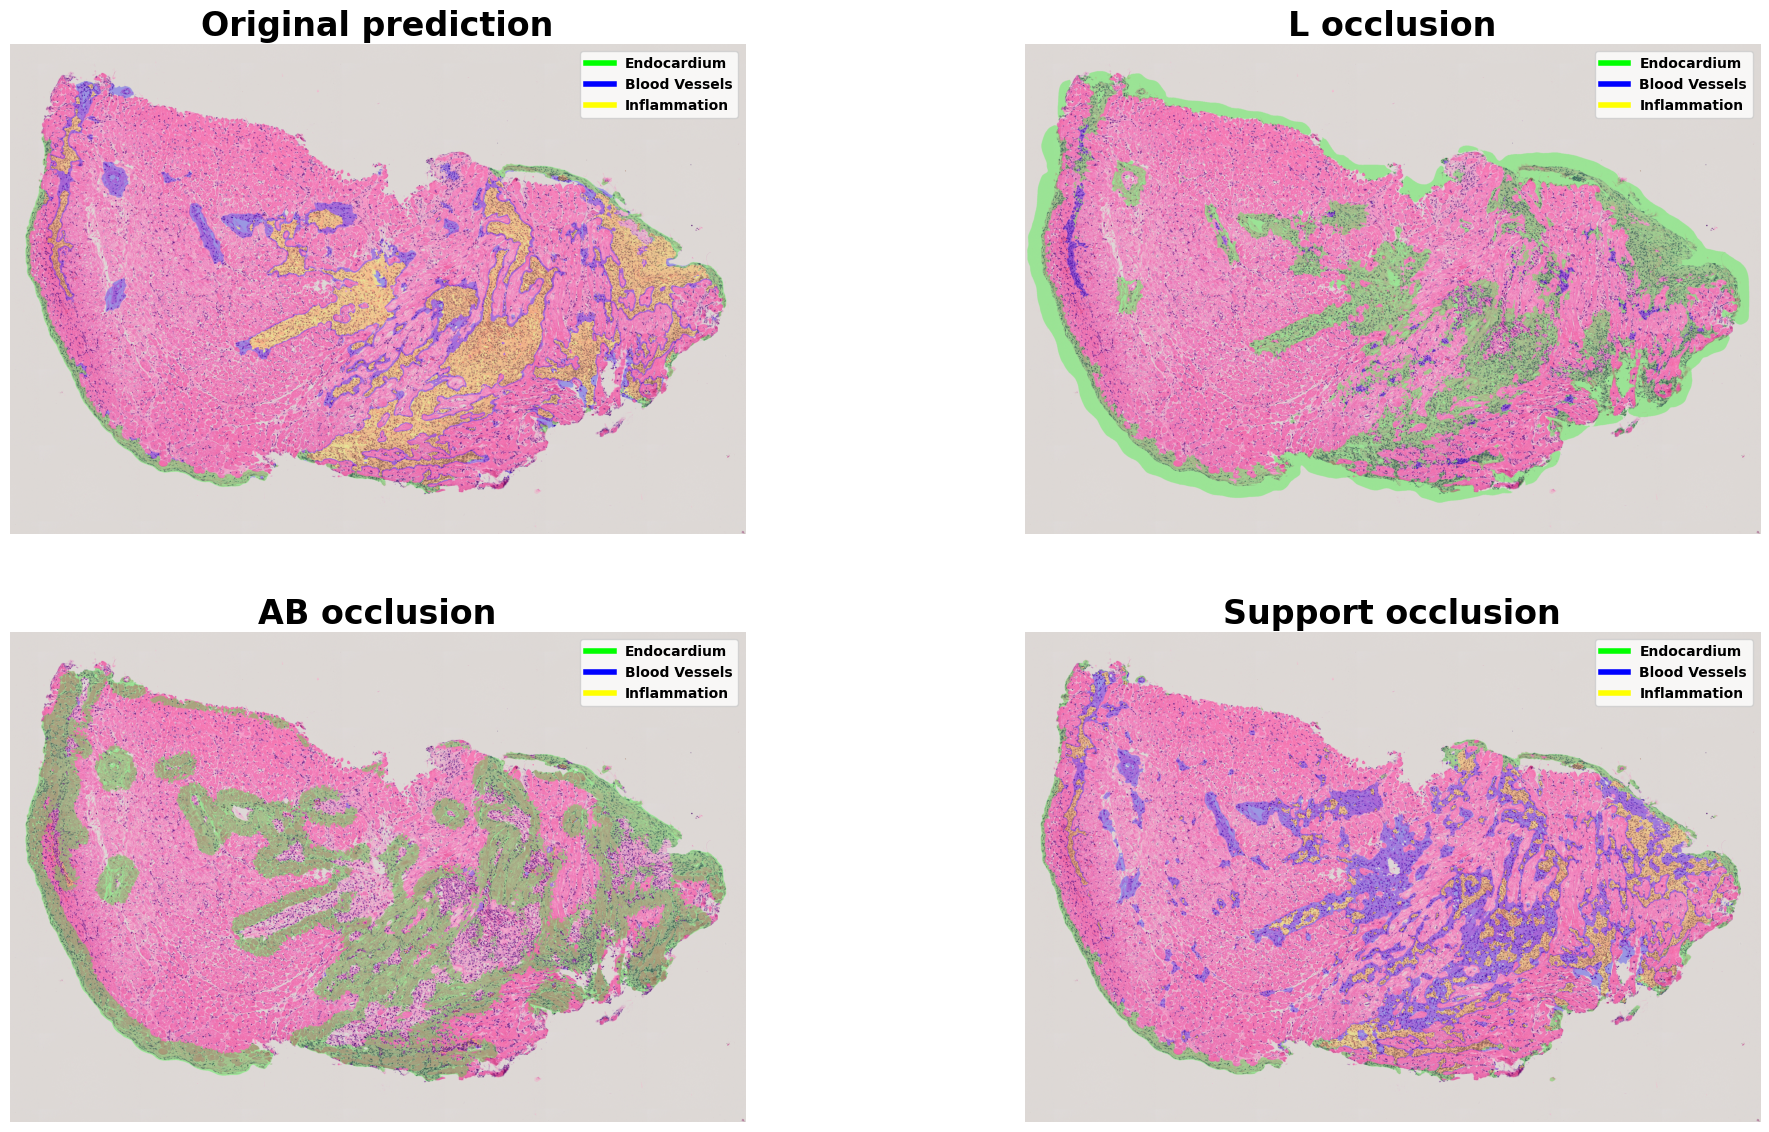

In [92]:
%matplotlib inline
pred, labels = vis_interpretability_binary_v2(test_wsis[0], mode, name, 2)

In [23]:
for c_idx, cname in zip([1, 2, 3],  ['Endocardium', 'Blood Vessels', 'Inflammation']):
    out_seg = np.where(pred == c_idx, 1, 0)
    out_labels = np.where(labels == c_idx, 1, 0)
    
    dice = np.sum(out_seg[out_labels==1])*2.0 / (np.sum(out_seg) + np.sum(out_labels))
    print(f"{cname} Dice: {dice}")

Endocardium Dice: 0.572189647274393
Blood Vessels Dice: 0.15682968793260293
Inflammation Dice: 0.8709782476403117


## Multiclass supporting information model

In [24]:
def vis_interpretability_multiclass_v2(wsi_path, mode, name, part):
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(24,14))
    if 'nuclei'in name:
        out_name = wsi_path.split('-')[0].replace("./test_data/nuclei_src\\", "")
    else:
        out_name = wsi_path.split('-')[0].replace("./test_data/cell_src\\", "")
    start_time = time.time()
    # wsi = np.transpose(tiff.imread(wsi_path), (2, 0, 1))
    img = np.load(wsi_path)# [:3, :, :]
    org = img[4, :, :]


    pred = np.load(f"../output/structure_seg/{mode}/{name}_original_7026_part_{part}.npy")
    l_pred = np.load(f"../output/structure_seg/{mode}/{name}_L_7026_part_{part}.npy")
    ab_pred = np.load(f"../output/structure_seg/{mode}/{name}_AB_7026_part_{part}.npy")
    immune_pred = np.load(f"../output/structure_seg/{mode}/{name}_immune_7026_part_{part}.npy")
    muscle_pred = np.load(f"../output/structure_seg/{mode}/{name}_muscle_7026_part_{part}.npy")
    other_pred = np.load(f"../output/structure_seg/{mode}/{name}_other_7026_part_{part}.npy")


    out = np.load(wsi_path)

    labels = np.where((out[4, :, :] == 5) | (out[4, :, :] == 6), 3, out[4, :, :])
    labels = np.where(labels == 7, 1, labels)


    out = out[:3]#, 4000:5500, 1000:4000]
    labels = labels#[4000:5500, 1000:4000]
    
    if downscaled:
        out = cv2.resize(out.transpose(1, 2, 0), (out.shape[2]//2, out.shape[1]//2)).transpose(2, 0, 1)
        labels = cv2.resize(labels, (labels.shape[1]//2, labels.shape[0]//2))
        
    org_out, immune_out, muscle_out, other_out = out.copy(), out.copy(), out.copy(), out.copy()    
    for color, c_idx in zip([(0, 255, 0), (0, 0, 255), (255, 255, 0)], range(1, 4)):
        pred_contours, _ = cv2.findContours(np.where(pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        immune_contours, _ = cv2.findContours(np.where(immune_pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        muscle_contours, _ = cv2.findContours(np.where(muscle_pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        other_contours, _ = cv2.findContours(np.where(other_pred == c_idx, 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if c_idx == 1:
            org_out = np.ascontiguousarray(org_out.transpose(1, 2, 0), dtype=np.uint8)
            immune_out = np.ascontiguousarray(immune_out.transpose(1, 2, 0), dtype=np.uint8)
            muscle_out = np.ascontiguousarray(muscle_out.transpose(1, 2, 0), dtype=np.uint8)
            other_out = np.ascontiguousarray(other_out.transpose(1, 2, 0), dtype=np.uint8)
            
        cv2.drawContours(org_out, pred_contours, -1, color, thickness=cv2.FILLED)   
        cv2.drawContours(immune_out, immune_contours, -1, color, thickness=cv2.FILLED)   
        cv2.drawContours(muscle_out, muscle_contours, -1, color, thickness=cv2.FILLED)   
        cv2.drawContours(other_out, other_contours, -1, color, thickness=cv2.FILLED)   
        
    custom_lines = [Line2D([0], [0], color="#00ff00", lw=4),
                    Line2D([0], [0], color="#0000ff", lw=4),
                    Line2D([0], [0], color="#ffff00", lw=4)]

    alpha = 0.3
    org_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, org_out, alpha, 0)
    ax[0, 0].imshow(org_out)
    # ax[0, 0].imshow(np.where(pred==0, np.nan, pred), vmin=1, vmax=4, cmap='Dark2')
    ax[0, 0].set_title("Original prediction", fontsize=24, fontweight='bold')
    ax[0, 0].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[0, 0].axis('off')
    
    immune_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, immune_out, alpha, 0)
    ax[0, 1].imshow(immune_out)
    # ax[0, 1].imshow(np.where(l_pred==0, np.nan, l_pred), vmin=1, vmax=4, cmap='Dark2')
    ax[0, 1].set_title("Immune cells occlusion", fontsize=24, fontweight='bold')
    ax[0, 1].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[0, 1].axis('off')
    
    muscle_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, muscle_out, alpha, 0)
    ax[1, 0].imshow(muscle_out)
    # ax[1, 0].imshow(np.where(ab_pred==0, np.nan, ab_pred), vmin=1, vmax=4, cmap='Dark2')
    ax[1, 0].set_title("Muscle cells occlusion", fontsize=24, fontweight='bold')
    ax[1, 0].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[1, 0].axis('off')
    
    other_out = cv2.addWeighted(out.transpose(1, 2, 0), 1-alpha, other_out, alpha, 0)
    ax[1, 1].imshow(other_out)
    # ax[1, 1].imshow(np.where(support_pred==0, np.nan, support_pred), vmin=1, vmax=4, cmap='Dark2')
    ax[1, 1].set_title("Other cells occlusion", fontsize=24, fontweight='bold')
    ax[1, 1].legend(custom_lines, ['Endocardium', 'Blood Vessels', 'Inflammation'], prop={'weight':'bold'})
    ax[1, 1].axis('off')

    plt.show()
    
    return pred, labels

In [25]:
mode = "multiclass"
name = "Multiclass_cells_LAB_gnorm_scaled_diceloss_slower"

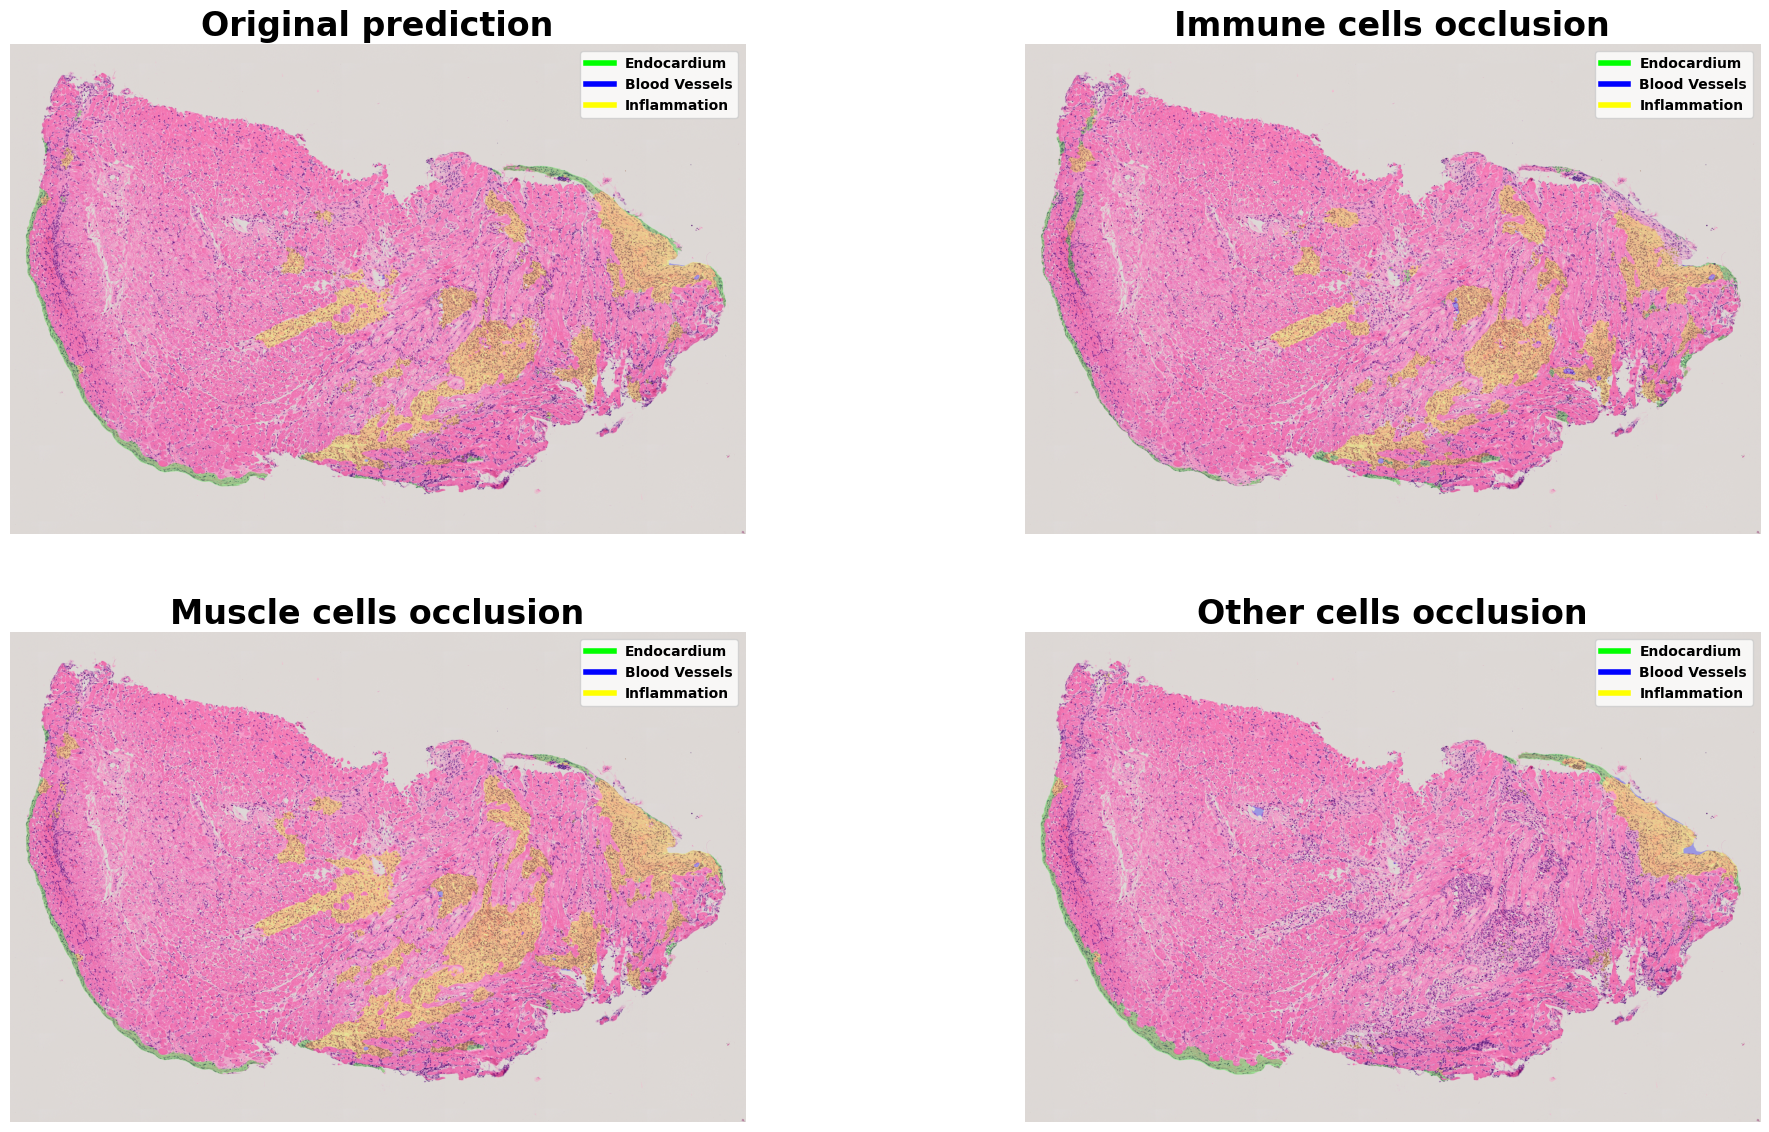

In [26]:
pred, labels = vis_interpretability_multiclass_v2(test_wsis[0], mode, name, 2)

In [27]:
for c_idx, cname in zip([1, 2, 3],  ['Endocardium', 'Blood Vessels', 'Inflammation']):
    out_seg = np.where(pred == c_idx, 1, 0)
    out_labels = np.where(labels == c_idx, 1, 0)
    
    dice = np.sum(out_seg[out_labels==1])*2.0 / (np.sum(out_seg) + np.sum(out_labels))
    print(f"{cname} Dice: {dice}")

Endocardium Dice: 0.6209584354649753
Blood Vessels Dice: 0.007047464674583319
Inflammation Dice: 0.6940760533331751
